In [ ]:
# # model.fair_fill_data(time_horizon=time_horizon, scenarios=["ssp245"])
# # model.test_init_fair(scenarios=["ssp245"], time_horizon=time_horizon)
# model.species_configs
# model.configs
from src.enumerations import *
scenario = SSP.SSP1
fair_scenario = [(ssp_to_rcp[scenario]).value]

model.fair_justice_run_init(time_horizon=time_horizon, scenarios=fair_scenario)

print(fair_scenario)

In [ ]:
# time_horizon.start_year - 1750

print(model.__getattribute__('number_of_ensembles'))

In [ ]:
loop_counter =  model.__getattribute__("fair_historical_timestep_run_count")
print(loop_counter)

In [ ]:
"""
#This is for FAIR #Loop should run till (len(justice_run_years) -1 )
for i in range(loop_counter, (len(justice_run_years) - 1 )): # This works. The justice loop should run from loop counter and end with the last year of the justice run
    print(i , justice_run_years[i])
    # print(i)
    # start_time = time.time()
    model.stepwise_run(i)
    # end_time = time.time()  # palok
    # elapsed_time = end_time - start_time  # calculate the difference
    # f.calculate_toa_ocean_airborne_fraction()
    # f.prepare_output_xarrays()


"""

In [ ]:
#Shape: timepoints, scenarios and ensemblemodels
current_emissions = model.emissions.sel(specie="CO2 FFI", scenario=fair_scenario)
#Plots the current emissions
current_emissions = current_emissions[:,0,:]

# NEW EXPERIMENTS OF INTEGRATION

In [1]:
from src.economy.neoclassical import NeoclassicalEconomyModel
from src.emissions.emission import OutputToEmissions
#from economy.neoclassical import NeoclassicalEconomyModel
from src.data_loader import DataLoader
from src.enumerations import *
from src.model_time import TimeHorizon
from src.climate.temperature_downscaler import TemperatureDownscaler
# Instantiate the data loader
from src.climate.coupled_fair import CoupledFAIR
from src.enumerations import *
import pandas as pd
import numpy as np
from src.damage.kalkuhl import DamageKalkuhl




In [2]:
scenario = SSP.SSP1
fair_scenario = [(ssp_to_rcp[scenario]).value]



# Load the data
data_loader = DataLoader()


# Instantiate the TimeHorizon class
time_horizon = TimeHorizon(start_year=2015, end_year=2300, data_timestep=5, timestep=1)

model = CoupledFAIR()
downscaler = TemperatureDownscaler(input_dataset = data_loader)

model.fair_justice_run_init(time_horizon=time_horizon, scenarios=fair_scenario)

damage_function = DamageKalkuhl(input_dataset=data_loader, time_horizon=time_horizon, climate_model=model)

In [3]:
no_of_ensembles = model.__getattribute__('number_of_ensembles')
print(no_of_ensembles)
economy = NeoclassicalEconomyModel(input_dataset = data_loader, time_horizon=time_horizon, climate_ensembles=no_of_ensembles)
emissions = OutputToEmissions(input_dataset=data_loader, time_horizon=time_horizon, climate_ensembles=no_of_ensembles)


1001


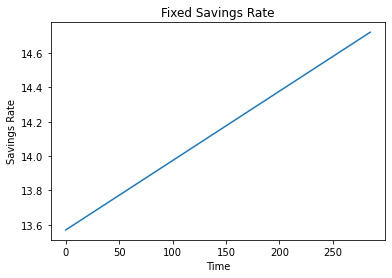

In [4]:

#Create a fixed savings rate
fixed_savings_rate = np.copy(data_loader.SAVING_RATE_INIT_ARRAY).reshape(-1, 1)
#fixed_savings_rate Validated with RICE50 for timestep 1 and 5

set_year = time_horizon.model_time_horizon


for i, years in enumerate(set_year):
    
    t = i+1 #index starts at 0, so add 1 to get the year

    if t != 1: # no need to repeat for the first year

        next_rate = data_loader.SAVING_RATE_INIT_ARRAY + (economy.get_optimal_long_run_savings_rate() - data_loader.SAVING_RATE_INIT_ARRAY)*((t - 1)/(len(set_year) - 1))
        # append to the fixed savings rate array for each year
        fixed_savings_rate = np.column_stack((fixed_savings_rate, next_rate))

from matplotlib import pyplot as plt
plt.plot(np.sum(fixed_savings_rate, axis=0))
plt.title("Fixed Savings Rate")
plt.xlabel("Time")
plt.ylabel("Savings Rate")
plt.show()

In [5]:
scenario = 0 #SSP.SSP1
#print(scenario.value)

# temp_emissions = np.zeros((57, 286, 1001))
damage = np.zeros((57, 286, 1001))
# Regional temperature array
#regional_temperature = np.zeros((57, 286, 1001))

for i in (range(len(set_year) - 1)):

    output = economy.run(scenario = scenario, timestep=i, savings_rate=fixed_savings_rate[:, i])

    emissions_array = emissions.run_emissions(timestep=i, scenario=scenario, output=output, emission_control_rate=0.0) #[:,i,:]

    total_emissions = np.sum(emissions_array, axis=0)

    
    global_temperature = model.compute_temperature_from_emission(i, total_emissions)
    regional_temperature = downscaler.get_regional_temperature(global_temperature)
    damage[:,i,:] = damage_function.calculate_damage(temperature=regional_temperature, timestep=i)

    economy.apply_damage_to_output(timestep=i+1, damage = damage[:,i,:])







    



got damages [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
got damages [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
got damages [[ 2.50659247e-04  5.00401552e-04  1.53250031e-03 ...  2.85057522e-03
  -5.26022380e-04  3.22189940e-04]
 [ 2.82377492e-04  5.63732696e-04  1.72658974e-03 ...  3.21191836e-03
  -5.92549942e-04  3.62961598e-04]
 [ 6.10951923e-05  1.21953075e-04  3.73311575e-04 ...  6.93975441e-04
  -1.28256857e-04  7.85273946e-05]
 ...
 [ 2.03988538e-04  4.07219502e-04  1.24698277e-03 ...  2.31914835e-03
  -4.28118442e-04  2.62198704e-04]
 [ 4.12966670e-04  8.24502622e-04  2.52608529e-03 ...  4.70112862e-03
  -8.66372124e-04  5.30829819e-04]
 [ 3.09398173e-04  6.17686210e-04  1.89196374e-03 ...  3.51985794e-03
  -6.49218392e-04  3.97695206e-04]]
got damages [[ 1

In [7]:
output = economy.__getattribute__('output')
print(output.shape)

testdf = output[:, :, 0]

(57, 286, 1001)


In [6]:
testdf2 = damage[:, :, 724]

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
testdf2 = regional_temperature[:,:, 0] 

In [17]:
#temperature = model.get_temperature_array()

temp = model.temperature.loc[dict(scenario="ssp119", layer=0)]

# Find the maximum temperature in temperature array
max_temp = np.max(temp)
print(max_temp)
#find the index of the maximum temperature
max_temp_index = np.where(temp == max_temp)

<xarray.DataArray ()>
array(2.97188026)
Coordinates:
    scenario  <U6 'ssp119'
    layer     int64 0


In [12]:
model.calculate_toa_ocean_airborne_fraction()
model.prepare_output_xarrays()

Text(0, 0.5, 'Temperature anomaly (K)')

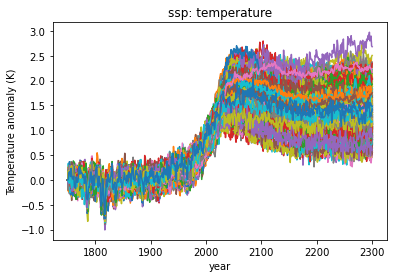

In [13]:
import matplotlib.pyplot as pl
pl.plot(model.timebounds, model.temperature.loc[dict(scenario="ssp119", layer=0)], label=model.configs);
pl.title('ssp: temperature')
pl.xlabel('year')
pl.ylabel('Temperature anomaly (K)')

In [ ]:
model.temperature.loc[dict(scenario="ssp119", layer=0)].shape

In [ ]:
import matplotlib.pyplot as pl
temperature = model.get_temperature_array()



#Plot temp array of shape (551, 1001) where 551 is the number of years and 1001 is the number of ensembles
# Shape [timestep, scenario, ensemble, box/layer=0]
temp = temperature[:,0,:,0]
print(temp.shape)

#Shape: timepoints, scenarios and ensemblemodels
pl.plot(model.timebounds, temp, label=model.configs);
pl.title('ssp: temperature')
pl.xlabel('year')
pl.ylabel('Temperature anomaly (K)')

In [ ]:
#Extracting the temperature data

temp = model.temperature.loc[dict(scenario=fair_scenario, layer=0)]
temp.name = 'temperature'
temp_df = temp.to_dataframe().reset_index()


In [ ]:
total_emis_test = emissions_array #[:,:,0]
#sum all the emissions of regions per timestep to get total emissions for each timestep
total_emis_test = np.sum(total_emis_test, axis=0)
#testdf = pd.DataFrame(emissions_array[:,:,0])


In [ ]:

testdf = pd.DataFrame(model.emissions.sel(specie="CO2 FFI", scenario="ssp119"))

In [ ]:
testdf2 = total_emissions[:,:,0]

In [ ]:
testdf2 = emissions_array[:,:,0]